In [127]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report,precision_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [128]:
#!pip install --upgrade scikit-learn imbalanced-learn

In [129]:
df=pd.read_csv('smoke_detection_iot.csv')

In [130]:
df.sample()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
34408,34408,1654770757,20.44,61.28,637,575,12852,19619,939.199,3.08,3.2,21.19,3.305,0.075,9414,1


In [131]:
drop1=['Unnamed: 0','UTC','CNT']
for col in drop1:
    df=df.drop(col, axis=1)
    


In [132]:
df.sample()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
46162,24.57,53.3,1346,404,12956,19400,938.676,2.08,2.16,14.34,2.236,0.051,1


In [133]:

df.shape[0]

62630

In [134]:
df['Fire Alarm'].value_counts()/df.shape[0]*100

Fire Alarm
1    71.462558
0    28.537442
Name: count, dtype: float64

In [135]:
df.corr()['Fire Alarm']

Temperature[C]   -0.163902
Humidity[%]       0.399846
TVOC[ppb]        -0.214743
eCO2[ppm]        -0.097006
Raw H2            0.107007
Raw Ethanol      -0.340652
Pressure[hPa]     0.249797
PM1.0            -0.110552
PM2.5            -0.084916
NC0.5            -0.128118
NC1.0            -0.082828
NC2.5            -0.057707
Fire Alarm        1.000000
Name: Fire Alarm, dtype: float64

In [136]:
df.isnull().sum()

Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
Fire Alarm        0
dtype: int64

In [137]:
x=df.iloc[:,:12]
y=df.iloc[:,-1]

In [138]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,shuffle=True)


In [151]:
pipe=imbPipeline([('standard',StandardScaler()),('oversample', RandomOverSampler(random_state=42)),('pca',PCA(n_components=2)),('RandomForestClassifier',RandomForestClassifier())])

In [152]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('standard', StandardScaler()),
                ('oversample', RandomOverSampler(random_state=42)),
                ('pca', PCA(n_components=2)),
                ('RandomForestClassifier', RandomForestClassifier())])

In [153]:
y_pred=pipe.predict(X_test)

In [154]:
accuracy_score(y_pred,y_test)

0.9198467188248444

In [155]:
precision_score(y_pred,y_test)

0.9393193013882669

In [156]:
report=classification_report(y_pred,y_test)

In [157]:
print(report)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3674
           1       0.94      0.95      0.94      8852

    accuracy                           0.92     12526
   macro avg       0.91      0.90      0.90     12526
weighted avg       0.92      0.92      0.92     12526



In [160]:
result=cross_val_score(pipe,X_train,y_train,cv=5,verbose=2,n_jobs=-1)
result.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.5s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.5s finished


0.9151964148740739

In [161]:
X_train_pca = pipe.named_steps['pca'].transform(X_train)
X_test_pca = pipe.named_steps['pca'].transform(X_test)

C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_7028\1533896130.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


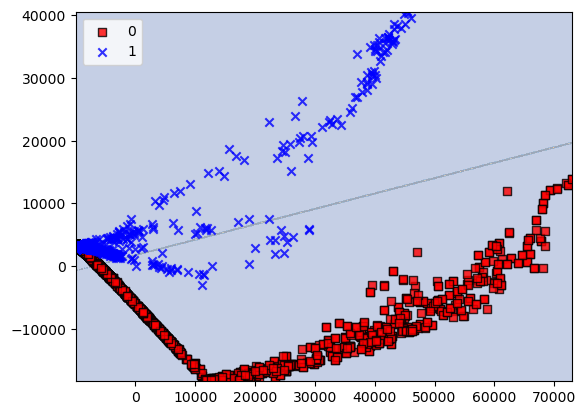

In [162]:
def plot_decision_boundary(pipe, X, y, pca, resolution=100.0):
    # Setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = plt.cm.RdYlBu

    # Create a mesh grid with reduced resolution
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # Predict the classifier output for all grid points
    Z = pipe.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot all samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    plt.legend(loc='upper left')
    plt.show()

# Plot the decision boundary for the training set
plot_decision_boundary(pipe, X_train_pca, y_train, pipe.named_steps['pca'])

In [163]:
#score=cross_val_score(pipe,X_train,y_train,cv=5)
#score.mean()

In [167]:
with open('fire_dedection_pca_uversampler.pkl','wb') as file:
    pickle.dump(pipe,file)
    


In [168]:
X_train.sample()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
55442,43.46,29.81,5586,400,13048,19603,936.879,0.81,0.84,5.54,0.865,0.02


In [169]:
X_train.describe()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
count,50104.000000,50104.000000,50104.000000,50104.000000,50104.000000,50104.000000,50104.000000,50104.000000,50104.000000,50104.000000,50104.000000,50104.000000
mean,15.928655,48.561158,1934.006427,668.293869,12942.827718,19753.936293,938.632390,98.008636,180.219835,477.590807,198.943859,78.470617
std,14.362195,8.842018,7784.396278,1910.771684,271.786522,607.599277,1.323626,907.294329,1959.213724,4167.675852,2196.808023,1080.670415
min,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.889250,47.540000,129.000000,400.000000,12830.000000,19435.000000,938.700000,1.290000,1.340000,8.870000,1.387750,0.033000
50%,20.102000,50.160000,982.000000,400.000000,12924.000000,19500.000000,938.816000,1.810000,1.880000,12.450000,1.942000,0.044000
75%,25.400000,53.250000,1189.000000,438.000000,13109.000000,20077.250000,939.420000,2.090000,2.180000,14.420000,2.249000,0.051000
max,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000
